In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cohlib.utils import gamma_root
gamma_root()

'/projectnb/stephenlab/jtauber/cohlib/hydra/gammas'

In [3]:
def plot_jvo(jax_output, old_output, k, pltlim, suptitle, showyx=True):
    if pltlim is None:
        all_output = jnp.concatenate([jax_output[:,k].real, jax_output[:,k].imag, 
            old_output[:,k].real, old_output[:,k].imag])
        pltlim = all_output.max() * 1.2

    yxline = jnp.linspace(-pltlim, pltlim, 100)
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    ax[0].plot(jax_output[:,k].real, old_output[:,k].real, '.')
    ax[0].set_title('Real')

    ax[1].plot(jax_output[:,k].imag, old_output[:,k].imag, '.')
    ax[1].set_title('Imag')

    for i in range(2):
        ax[i].set_xlim([-pltlim, pltlim])
        ax[i].set_ylim([-pltlim, pltlim])
        if showyx is True:
            ax[i].plot(yxline, yxline, 'k')
        ax[i].set_xlabel('Jax')
        ax[i].set_ylabel('Old')

    fig.suptitle(suptitle)
    plt.tight_layout()

In [4]:
import os
import shutil
from pathlib import Path
import jax.numpy as jnp
import jax.random as jr
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

from cohlib.jax.ts_gaussian import load_results

In [5]:
def clean_dir(path):
    paths_to_remove = []
    _dir = Path(path)
    for i, exp in enumerate(_dir.glob('*')):
        exp_path = Path(exp)
        contents = []
        for f in exp_path.glob('*'):
            contents.append(os.path.split(f)[1])
        if 'res.pickle' not in contents: 
            shutil.rmtree(exp_path)
            print('Removing unfinished experiment')

### Data setup

In [6]:
flow = 1
fhigh = 50
scale_power = 3

gamma_load = pickle_open(f'../gammas/k2-flat{flow}-{fhigh}-{scale_power}.pickle')
# gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']
# K = gamma_full.shape[1]
K = 2

In [7]:
from pathlib import Path
from omegaconf import OmegaConf
def load_results_modm(paths, ovs_sel, ts_flag=False, **kwargs):
    Lpaths = get_model_paths_modm(paths, ts_flag, **kwargs)
    results = {}
    obs_vars = []
    for path in Lpaths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)
        obs_var = cfg.obs.ov2
        if ovs_sel is not None:
            if obs_var in ovs_sel:
                obs_vars.append(obs_var)

    ovs = jnp.array(obs_vars)
    if ovs.size == jnp.unique(ovs).size:

        for path in Lpaths:
            cfg_path = os.path.join(path, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)
            obs_var = cfg.obs.ov2

            res = pickle_open(os.path.join(path, 'res.pickle'))
            res['cfg'] = cfg
            results[obs_var] = res

    else:
        print('Duplicates found for obs_var - returning empty dict.')

    return results

def get_model_paths_modm(paths, ts_flag, **kwargs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)
            res_path = os.path.join(exp, 'res.pickle')
            res = pickle_open(res_path)

            ts = res.get('ts_run')
            if ts is None:
                ts = False

            if ts is True:
                method = res.get('method')
                if method is None:
                    method = 'jax'
            else:
                method = None

            if ts == ts_flag:
                if method == kwargs['method']:
                    if cfg.latent.L == kwargs['L']:
                        if cfg.model.m_step_mod == kwargs['m_step_mod']:
                            if cfg.model.emiters == kwargs['emiters']:
                                if cfg.model.init == kwargs['init']:
                                    # print(f'cfg scale_init: {cfg.model.scale_init}' )
                                    # print(f'kwargs scale_init: {kwargs["scale_init"]}' )
                                    # print(f'method: {kwargs["method"]}')
                                    if cfg.model.scale_init == kwargs['scale_init']:
                                        if kwargs['supp'] is not None:
                                            if 'support' in list(cfg.model.keys()):
                                                if cfg.model.support == kwargs['supp']:
                                                        sel_paths.append(exp)
                                        else:
                                            if 'support' not in list(cfg.model.keys()):
                                                if cfg.model.emiters == kwargs['emiters']:
                                                    sel_paths.append(exp)
                                            else:
                                                if cfg.model.support == kwargs['supp']:
                                                        sel_paths.append(exp)
                else:
                    pass
    return sel_paths

In [8]:
def sample_obs(gamma, result):
   cfg = result['cfg']
   lcfg = cfg['latent']
   ocfg = cfg['obs']

   lrk = jr.key(lcfg.seed)
   ork = jr.key(ocfg.seed)
   L = lcfg.L
   ov1 = ocfg.ov1
   ov2 = ocfg.ov2
   obs_var = ov1 * 10**ov2

   zs = sample_from_gamma(lrk, gamma, L)
   zs_0dc = jnp.apply_along_axis(add0, 0, zs)
   xs = jnp.fft.irfft(zs_0dc, axis=0)

   obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

   return obs


In [9]:

res_paths = ['outputs/2024-10-15', 'outputs/2024-10-16']
# res_paths_modm = ['/projectnb/stephenlab/jtauber/cohlib/hydra/debug_gaussian_obs/batch_submit/outputs/2024-10-17']
res_paths_modm = ['/projectnb/stephenlab/jtauber/cohlib/hydra/debug_gaussian_obs/batch_submit/outputs/2024-11-04']
clean_dir(res_paths[0])

L = 50
init = 'flat-init'
emiters = 20
# scale_init = 100000
scale_init = 1000
ovs_sel = None

supp = [0, 50]
res_load = load_results_modm(res_paths_modm, ovs_sel, m_step_mod='none', ts_flag=False, method=None, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
res_load_mod = load_results_modm(res_paths_modm, ovs_sel, m_step_mod='double-Ups', ts_flag=False, method=None, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
res_load_conj_mod = load_results_modm(res_paths_modm, ovs_sel, m_step_mod='double-Ups-conj-hess', ts_flag=False, method=None, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
# res_load_ts_jax = load_results(res_paths, ovs_sel, ts_flag=True, method='jax-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

res_load_ts_old_scipy = load_results(res_paths, ovs_sel, ts_flag=True, method='scipy-old', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
res_load_ts_oldmod_scipy = load_results(res_paths, ovs_sel, ts_flag=True, method='scipy-oldmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

res_load_ts_old_deconmod = load_results(res_paths, ovs_sel, ts_flag=True, method='old-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
res_load_ts_oldmod_deconmod = load_results(res_paths, ovs_sel, ts_flag=True, method='oldmod-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

In [10]:
res_load_conj_mod.keys()

dict_keys([0, 1, 2])

In [11]:
def plot_spec_em_iters(ax, gamma_iter_list, k, nz=None, dB=False):
    if nz is None:
        nz = jnp.arange(gamma_iter_list[0].shape[0])
    num_iters = len(gamma_iter_list)
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    for r, c in enumerate(color): 
        gamma_r = gamma_iter_list[r]
        S_r = gamma_r[nz,k,k].real
        if dB is True:
            S_r = 10*jnp.log10(S_r)
        ax.plot(S_r, color=c, linewidth=2, alpha=0.5)

In [12]:
def db_transform(S_x):
    return 10*jnp.log10(S_x + 1e-15)

def identity(S_x):
    return S_x

In [13]:
k = 0
dB = True

if dB is True:
    transform = db_transform
else:
    transform = identity


In [14]:
# ovs = [-1, 1]
# ovs = [1]
ovs = [0, 1, 2]
# ovs_ts_jax = [2]

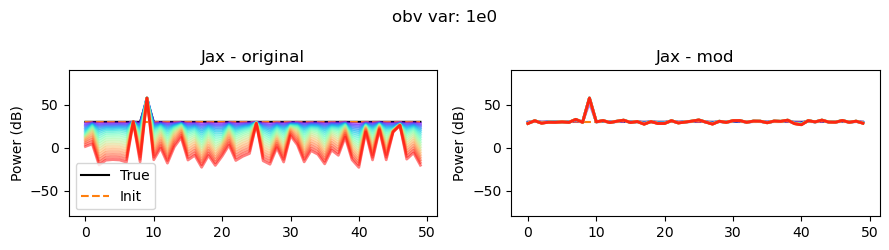

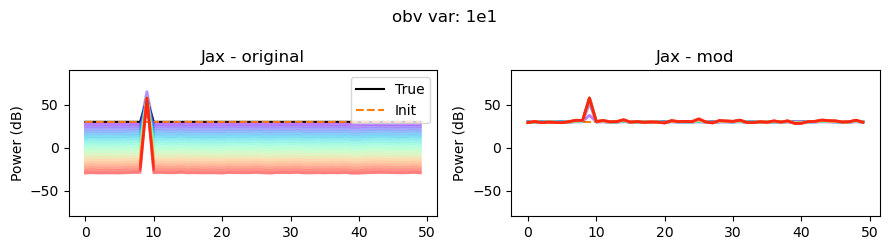

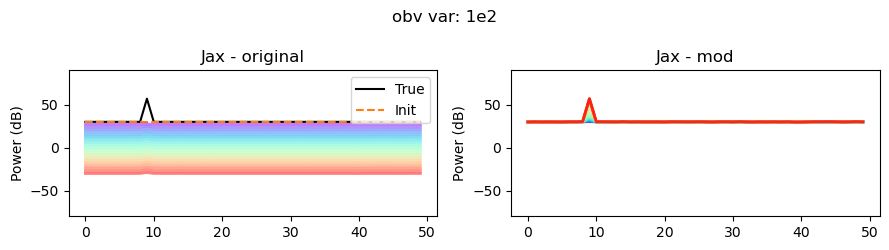

In [140]:
for ov2 in ovs:
    res_jax = res_load[ov2]
    # res_jax_mod = res_load_mod[ov2]
    res_jax_mod = res_load_conj_mod[ov2]


    gamma_init = res_jax['gamma_init']
    gamma_true = res_jax['gamma_true_full'][nz,:,:]
    S_true = transform(gamma_true[:,k,k].real)
    S_init = transform(gamma_init[:,k,k].real)

    fig, ax = plt.subplots(1,2, figsize=(9,2.5), sharex=True)
    fig.suptitle(f'obv var: 1e{ov2}')
    ax[0].plot(S_true, 'k', label='True')
    ax[1].plot(S_true, 'k')
    ax[0].plot(S_init, '--', color='tab:orange', label='Init')
    ax[1].plot(S_init, '--', color='tab:orange')
    plot_spec_em_iters(ax[0], res_jax['track']['gamma'], k, dB=True)
    ax[0].set_title('Jax - original')
    plot_spec_em_iters(ax[1], res_jax_mod['track']['gamma'], k, dB=True)
    ax[1].set_title('Jax - mod')
    if dB is True:
        ylabel = 'Power (dB)'
    else:
        ylabel = "Power"
    ax[0].legend()
    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel(ylabel)
    ax[0].set_ylim([-80,90])
    ax[1].set_ylim([-80,90])

    plt.tight_layout()

In [34]:
# r = 9
# j = 0
# l = 0
# # res_ts_jax['track'].track_em_data['gamma']
# # res_ts_jax['track'].track_em_data['mus']
# print(res_jax['track']['Upss'][r][j,:,:,l])
# print(res_ts_jax['track'].track_em_data['Upss'][r][j,:,:,l])
# # right - deconstruct_real isn't used in any jax implementation

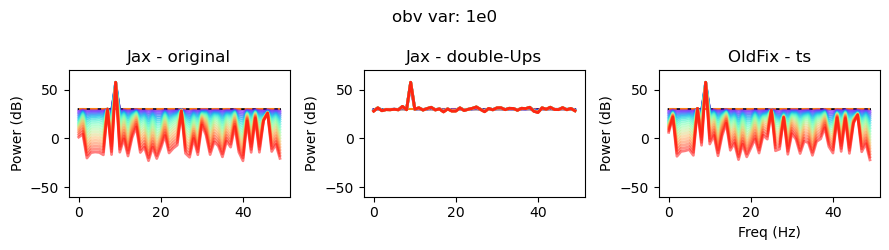

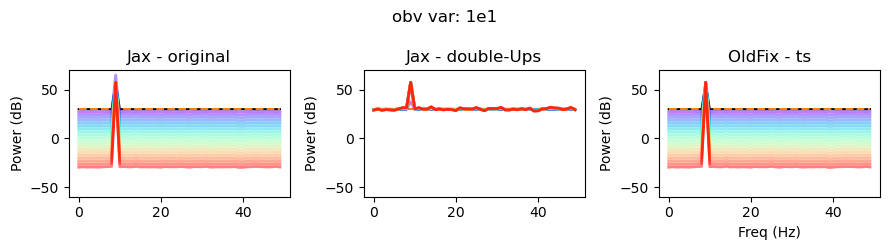

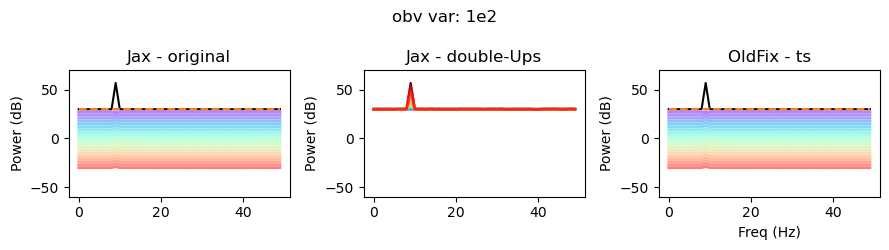

In [35]:
# for ov2 in [-3,-2,-1,0]:
for ov2 in ovs:
    res_jax = res_load[ov2]
    res_jax_mod = res_load_mod[ov2]
    # res_ts_jax = res_load_ts_jax[ov2]

    res_ts_old_deconmod = res_load_ts_old_deconmod[ov2]
    res_ts_oldmod_deconmod = res_load_ts_oldmod_deconmod[ov2]

    gamma_init = res_jax['gamma_init']
    gamma_true = res_jax['gamma_true_full'][nz,:,:]
    S_true = transform(gamma_true[:,k,k].real)
    S_init = transform(gamma_init[:,k,k].real)

    fig, ax = plt.subplots(1,3, figsize=(9,2.5), sharex=True)
    fig.suptitle(f'obv var: 1e{ov2}')
    ax[0].plot(S_true, 'k')
    ax[1].plot(S_true, 'k')
    ax[2].plot(S_true, 'k')
    ax[0].plot(S_init, '--', color='tab:orange', label='Init')
    ax[1].plot(S_init, '--', color='tab:orange')
    ax[2].plot(S_init, '--', color='tab:orange')
    plot_spec_em_iters(ax[0], res_jax['track']['gamma'], k, dB=dB)
    ax[0].set_title('Jax - original')
    plot_spec_em_iters(ax[1], res_jax_mod['track']['gamma'], k, dB=dB)
    ax[1].set_title('Jax - double-Ups')
    plot_spec_em_iters(ax[2], res_ts_oldmod_deconmod['track'].track_em_data['gamma'], k, dB=dB)
    ax[2].set_title('OldFix - ts')
    ax[2].set_xlabel('Freq (Hz)')
    if dB is True:
        ylabel = 'Power (dB)'
    else:
        ylabel = "Power"
    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel(ylabel)
    ax[2].set_ylabel(ylabel)
    # plot_spec_em_iters(ax[1], res_ts_oldmod_deconmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], res_ts_oldmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[2], scipy_oldmod_gamma_emtrack, k, dB=True)
    ax[0].set_ylim([-60,70])
    ax[1].set_ylim([-60,70])
    ax[2].set_ylim([-60,70])

    plt.tight_layout()

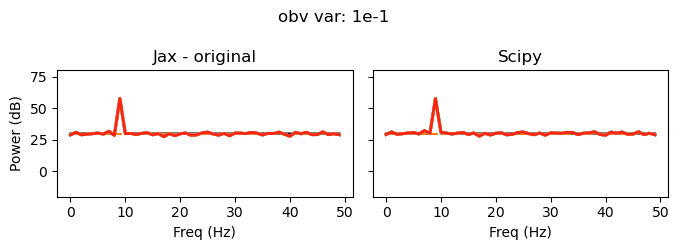

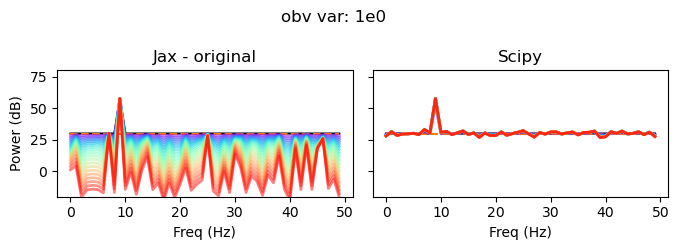

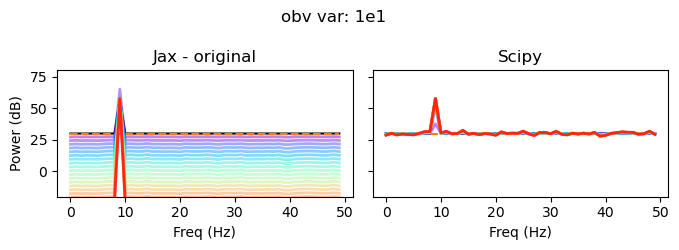

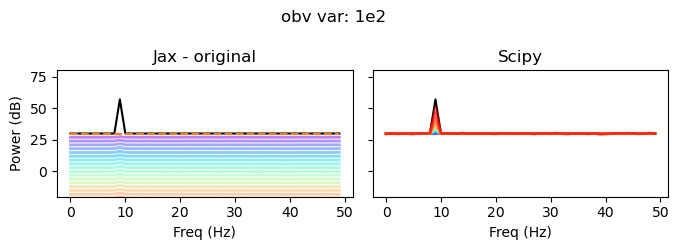

In [19]:
dB = True
for ov2 in ovs:
# for ov2 in [-3,-2,-1,0]:
    res_jax = res_load[ov2]
    res_jax_mod = res_load_mod[ov2]

    scipy_old_gamma_emtrack = [res_load_ts_old_scipy[ov2]['track'][0][r]['gamma_rplus1'] for r in range(emiters)]
    scipy_oldmod_gamma_emtrack = [res_load_ts_oldmod_scipy[ov2]['track'][0][r]['gamma_rplus1'] for r in range(emiters)]

    gamma_init = res_jax['gamma_init']
    gamma_true = res_jax['gamma_true_full'][nz,:,:]
    S_true = transform(gamma_true[:,k,k].real)
    S_init = transform(gamma_init[:,k,k].real)

    fig, ax = plt.subplots(1,2, figsize=(7,2.5), sharex=True, sharey=True)
    fig.suptitle(f'obv var: 1e{ov2}')
    ax[0].plot(S_true, 'k')
    ax[1].plot(S_true, 'k')
    ax[0].plot(S_init, '--', color='tab:orange', label='Init')
    ax[1].plot(S_init, '--', color='tab:orange')
    plot_spec_em_iters(ax[0], res_jax['track']['gamma'], k, dB=dB)
    ax[0].set_title('Jax - original')
    plot_spec_em_iters(ax[1], scipy_oldmod_gamma_emtrack, k, dB=dB)
    ax[1].set_title('Scipy')
    ax[0].set_xlabel('Freq (Hz)')
    ax[1].set_xlabel('Freq (Hz)')
    if dB is True:
        ylabel = 'Power (dB)'
    else:
        ylabel = "Power"
    ax[0].set_ylabel(ylabel)
    # ax[1].set_ylabel(ylabel)
    # ax[2].set_ylabel(ylabel)
    # plot_spec_em_iters(ax[1], res_ts_oldmod_deconmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], res_ts_oldmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[2], scipy_oldmod_gamma_emtrack, k, dB=True)

    ax[0].set_ylim([-20,80])
    ax[1].set_ylim([-20,80])
    # ax[2].set_ylim([-20,80])

    plt.tight_layout()

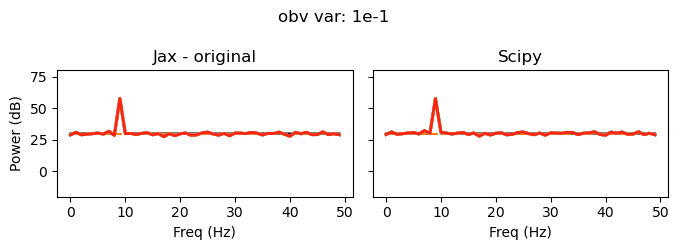

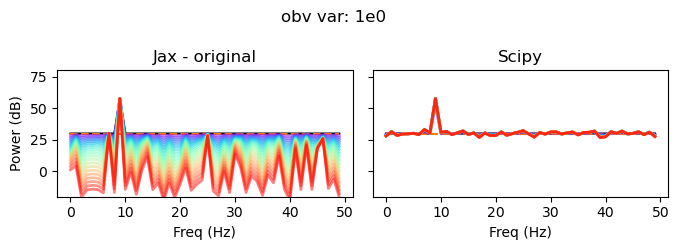

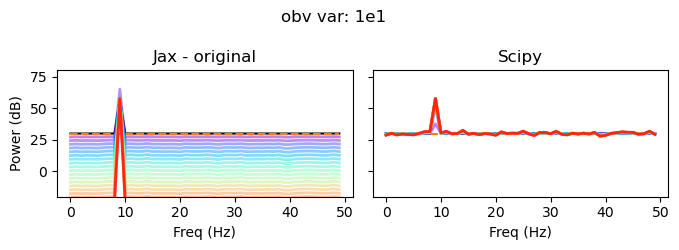

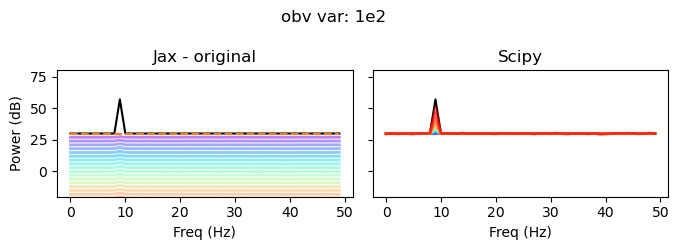

In [20]:
dB = True
for ov2 in ovs:
# for ov2 in [-3,-2,-1,0]:
    res_jax = res_load[ov2]
    res_jax_mod = res_load_mod[ov2]

    scipy_old_gamma_emtrack = [res_load_ts_old_scipy[ov2]['track'][0][r]['gamma_rplus1'] for r in range(emiters)]
    scipy_oldmod_gamma_emtrack = [res_load_ts_oldmod_scipy[ov2]['track'][0][r]['gamma_rplus1'] for r in range(emiters)]

    gamma_init = res_jax['gamma_init']
    gamma_true = res_jax['gamma_true_full'][nz,:,:]
    S_true = transform(gamma_true[:,k,k].real)
    S_init = transform(gamma_init[:,k,k].real)

    fig, ax = plt.subplots(1,2, figsize=(7,2.5), sharex=True, sharey=True)
    fig.suptitle(f'obv var: 1e{ov2}')
    ax[0].plot(S_true, 'k')
    ax[1].plot(S_true, 'k')
    ax[0].plot(S_init, '--', color='tab:orange', label='Init')
    ax[1].plot(S_init, '--', color='tab:orange')
    plot_spec_em_iters(ax[0], res_jax['track']['gamma'], k, dB=dB)
    ax[0].set_title('Jax - original')
    plot_spec_em_iters(ax[1], scipy_oldmod_gamma_emtrack, k, dB=dB)
    ax[1].set_title('Scipy')
    ax[0].set_xlabel('Freq (Hz)')
    ax[1].set_xlabel('Freq (Hz)')
    if dB is True:
        ylabel = 'Power (dB)'
    else:
        ylabel = "Power"
    ax[0].set_ylabel(ylabel)
    # ax[1].set_ylabel(ylabel)
    # ax[2].set_ylabel(ylabel)
    # plot_spec_em_iters(ax[1], res_ts_oldmod_deconmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], res_ts_oldmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[2], scipy_oldmod_gamma_emtrack, k, dB=True)

    ax[0].set_ylim([-20,80])
    ax[1].set_ylim([-20,80])

    plt.tight_layout()

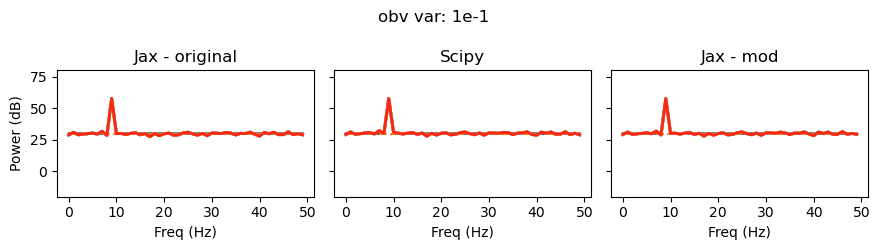

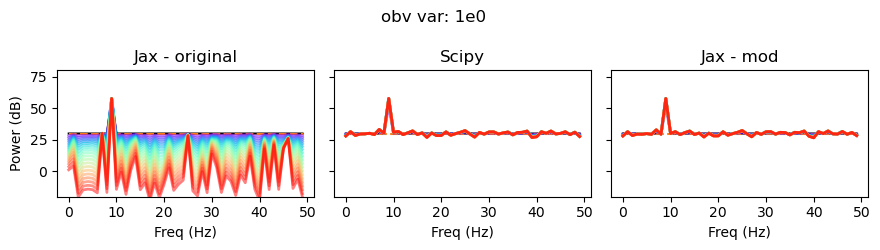

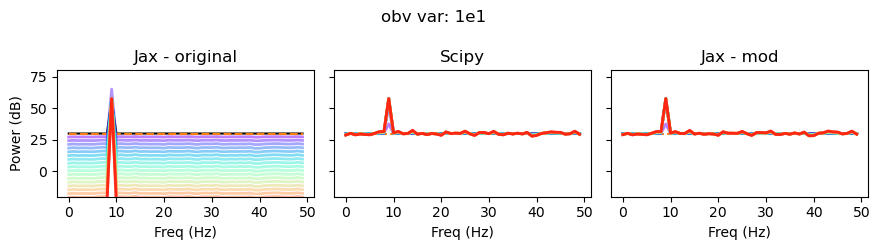

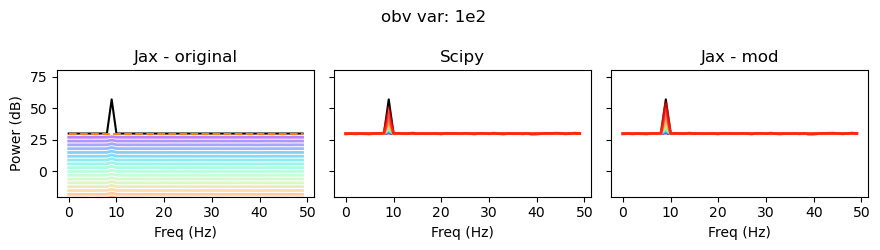

In [21]:
dB = True
for ov2 in ovs:
# for ov2 in [-3,-2,-1,0]:
    res_jax = res_load[ov2]
    res_jax_mod = res_load_mod[ov2]

    scipy_old_gamma_emtrack = [res_load_ts_old_scipy[ov2]['track'][0][r]['gamma_rplus1'] for r in range(emiters)]
    scipy_oldmod_gamma_emtrack = [res_load_ts_oldmod_scipy[ov2]['track'][0][r]['gamma_rplus1'] for r in range(emiters)]

    gamma_init = res_jax['gamma_init']
    gamma_true = res_jax['gamma_true_full'][nz,:,:]
    S_true = transform(gamma_true[:,k,k].real)
    S_init = transform(gamma_init[:,k,k].real)

    fig, ax = plt.subplots(1,3, figsize=(9,2.5), sharex=True, sharey=True)
    fig.suptitle(f'obv var: 1e{ov2}')
    ax[0].plot(S_true, 'k')
    ax[1].plot(S_true, 'k')
    ax[2].plot(S_true, 'k')
    ax[0].plot(S_init, '--', color='tab:orange', label='Init')
    ax[1].plot(S_init, '--', color='tab:orange')
    ax[2].plot(S_init, '--', color='tab:orange')
    plot_spec_em_iters(ax[0], res_jax['track']['gamma'], k, dB=dB)
    ax[0].set_title('Jax - original')
    plot_spec_em_iters(ax[1], scipy_oldmod_gamma_emtrack, k, dB=dB)
    ax[1].set_title('Scipy')
    plot_spec_em_iters(ax[2], res_jax_mod['track']['gamma'], k, dB=dB)
    ax[2].set_title('Jax - mod')
    ax[0].set_xlabel('Freq (Hz)')
    ax[1].set_xlabel('Freq (Hz)')
    ax[2].set_xlabel('Freq (Hz)')
    if dB is True:
        ylabel = 'Power (dB)'
    else:
        ylabel = "Power"
    ax[0].set_ylabel(ylabel)
    # ax[1].set_ylabel(ylabel)
    # ax[2].set_ylabel(ylabel)
    # plot_spec_em_iters(ax[1], res_ts_oldmod_deconmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], res_ts_oldmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[2], scipy_oldmod_gamma_emtrack, k, dB=True)

    ax[0].set_ylim([-20,80])
    ax[1].set_ylim([-20,80])
    ax[2].set_ylim([-20,80])

    plt.tight_layout()

In [36]:
# look at cross-spec / different values compared to true for here and others 

In [16]:
from cohlib.mvcn import thr_coherence

def plot_coh_em_iters(ax, gamma_iter_list, nz=None):
    if nz is None:
        nz = jnp.arange(gamma_iter_list[0].shape[0])
    num_iters = len(gamma_iter_list)
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    for r, c in enumerate(color): 
        gamma_r = gamma_iter_list[r]
        coh_r = thr_coherence(gamma_r[nz,:,:])
        ax.plot(coh_r, color=c, linewidth=2, alpha=0.5)

def plot_cross_spec_em_iters(ax, gamma_iter_list, gamma_init, j_ind=9, nz=None):
    cs_real = jnp.array([gamma_init[j_ind,0,1].real] + [gamma_r[j_ind,0,1].real for gamma_r in gamma_iter_list])
    cs_imag = jnp.array([gamma_init[j_ind,0,1].imag] + [gamma_r[j_ind,0,1].imag for gamma_r in gamma_iter_list])
    ax.plot(cs_real, color='tab:blue', linewidth=2)
    ax.plot(cs_imag, color='tab:red', linewidth=2)

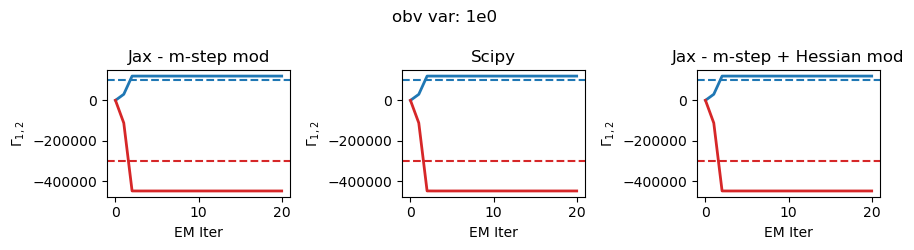

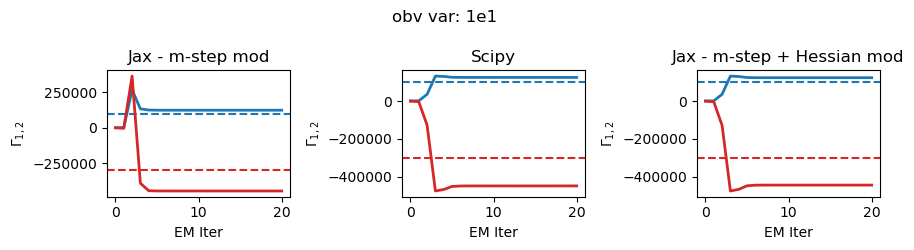

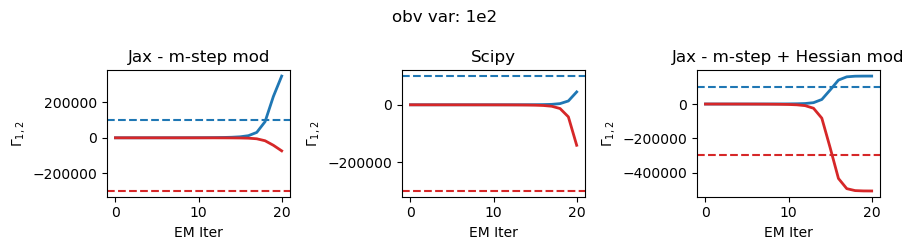

In [17]:
j_ind = 9
for ov2 in ovs:
    # res_jax = res_load[ov2]
    res_jax = res_load_mod[ov2]
    res_jax_mod = res_load_conj_mod[ov2]

    scipy_old_gamma_emtrack = [res_load_ts_old_scipy[ov2]['track'][0][r]['gamma_rplus1'] for r in range(emiters)]
    scipy_oldmod_gamma_emtrack = [res_load_ts_oldmod_scipy[ov2]['track'][0][r]['gamma_rplus1'] for r in range(emiters)]

    gamma_init = res_jax['gamma_init']
    gamma_true = res_jax['gamma_true_full'][nz,:,:]
    S_true = thr_coherence(gamma_true)
    S_init = thr_coherence(gamma_init)

    fig, ax = plt.subplots(1,3, figsize=(9,2.5), sharex=True)
    fig.suptitle(f'obv var: 1e{ov2}')
    ax[0].axhline(gamma_true[j_ind,0,1].real, linestyle='--', color='tab:blue')
    ax[1].axhline(gamma_true[j_ind,0,1].real, linestyle='--', color='tab:blue')
    ax[2].axhline(gamma_true[j_ind,0,1].real, linestyle='--', color='tab:blue')
    ax[0].axhline(gamma_true[j_ind,0,1].imag, linestyle='--', color='tab:red')
    ax[1].axhline(gamma_true[j_ind,0,1].imag, linestyle='--', color='tab:red')
    ax[2].axhline(gamma_true[j_ind,0,1].imag, linestyle='--', color='tab:red')
    plot_cross_spec_em_iters(ax[0], res_jax['track']['gamma'], gamma_init, j_ind)
    ax[0].set_title('Jax - m-step mod')
    plot_cross_spec_em_iters(ax[1], scipy_oldmod_gamma_emtrack, gamma_init, j_ind)
    ax[1].set_title('Scipy')
    plot_cross_spec_em_iters(ax[2], res_jax_mod['track']['gamma'], gamma_init, j_ind)
    ax[2].set_title('Jax - m-step + Hessian mod')
    ax[0].set_xlabel('EM Iter')
    ax[1].set_xlabel('EM Iter')
    ax[2].set_xlabel('EM Iter')
    ylabel = r"$\Gamma_{1,2}$"
    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel(ylabel)
    ax[2].set_ylabel(ylabel)

    # ax[0].set_ylim([-0.1,1])
    # ax[1].set_ylim([-0.1,1])
    # ax[2].set_ylim([-0.1,1])

    plt.tight_layout()

In [40]:
# res_load_mod[1]['params']

In [23]:
res_load[ov2]['track'].keys()

dict_keys(['mus', 'gamma', 'Upss'])

In [54]:
res_load_conj_mod[1]['params']

{'obs': {'obs_var': 10},
 'freqs': Array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171,

In [22]:
from cohlib.jax.ts_gaussian import conv_mu_old_r2c, deconstruct_Gamma_full_real_mod, deconstruct_Gamma_full_real
r = 1
ov2 = 1
num_J_vars = 100

gamma_jax_mod = res_load_mod[ov2]['track']['gamma'][r]
mus_jax_mod = res_load_mod[ov2]['track']['mus'][r]
Upss_jax_mod = res_load_mod[ov2]['track']['Upss'][r]

gamma_jax_conj_mod = res_load_conj_mod[ov2]['track']['gamma'][r]
mus_jax_conj_mod = res_load_conj_mod[ov2]['track']['mus'][r]
Upss_jax_conj_mod = res_load_conj_mod[ov2]['track']['Upss'][r]

gamma_scipy = res_load_ts_oldmod_scipy[ov2]['track'][0][r]['gamma_rplus1'] 
mus_scipy = res_load_ts_oldmod_scipy[ov2]['track'][0][r]['mus'] 
hess_scipy = res_load_ts_oldmod_scipy[ov2]['track'][0][r]['Ups_invs'] 

mus_scipy_complex = jnp.stack([conv_mu_old_r2c(mus_scipy[l,:], K) for l in range(L)], axis=-1)
hess_scipy_complex = jnp.stack([deconstruct_Gamma_full_real_mod(hess_scipy[l,:,:], K, num_J_vars) for l in range(L)], axis=-1)
Upss_scipy_complex = jnp.stack([jnp.linalg.inv(hess_scipy_complex[:,:,:,l]) for l in range(L)], axis=-1)

In [35]:
j = 9
l = 0
print('Trial = 0; Freq = 10Hz')
print('Jax Upsilon:')
print(jnp.round(Upss_jax_mod[j,:,:,l], 0))
print('\n')
print('Scipy Upsilon:')
print(jnp.round(Upss_scipy_complex[j,:,:,l], 0))

Trial = 0; Freq = 10Hz
Jax Upsilon:
[[1645.  -0.j  209.+752.j]
 [ 209.-752.j 1773.  +0.j]]


Scipy Upsilon:
[[1644.  +0.j  209.-755.j]
 [ 209.+755.j 1771.  -0.j]]


In [114]:
def m_step(mus_outer, Upss):
    return (mus_outer + Upss).mean(-1)

def m_step2(mus, Upss):
    mus_outer = jnp.einsum('nkl,nil->nkil', mus, mus.conj())
    return (mus_outer + Upss).mean(-1)

In [115]:
test_update_scipy = m_step2(mus_scipy_complex, 2*Upss_scipy_complex)
test_update_jax_mod = m_step2(mus_jax_mod, 2*Upss_jax_mod)
test_update_jax_conj_mod = m_step2(mus_jax_conj_mod, 2*Upss_jax_conj_mod.conj())

In [116]:
rd = 3
print(jnp.round(test_update_scipy[9,:,:], rd))
print(jnp.round(gamma_scipy[9,:,:], rd))

[[582577.44-3.0000000e-03j 124219.25-4.4729403e+05j]
 [124219.25+4.4729403e+05j 658023.3 +0.0000000e+00j]]
[[582570.6      +0.j  124149.97-447044.6j]
 [124149.97+447044.6j 658016.44     +0.j ]]


In [117]:
print(jnp.round(test_update_jax_mod[9,:,:], rd))
print(jnp.round(gamma_jax_mod[9,:,:], rd))

[[580937.6+0.00000e+00j 123766.9-4.45018e+05j]
 [123766.9+4.45018e+05j 656678.4+1.00000e-03j]]
[[580937.6      -0.j 123766.9 -445018.j]
 [123766.9 +445018.j 656678.44     -0.j]]


In [118]:
print(jnp.round(test_update_jax_conj_mod[9,:,:], rd))
print(jnp.round(gamma_jax_conj_mod[9,:,:], rd))

[[580910.5 -0.0000000e+00j 123767.1 -4.4554803e+05j]
 [123767.1 +4.4554803e+05j 656651.44+1.0000000e-03j]]
[[580910.5      +0.j   123767.1 -445548.03j]
 [123767.1 +445548.03j 656651.44     +0.j  ]]


In [132]:
j = 9
l = 0
jnp.linalg.inv(Upss_scipy_complex[j,:,:,l])

Array([[ 2.0703266e-04-3.3999043e-13j, -1.4775455e-06+5.3197873e-06j],
       [-1.4775455e-06-5.3197878e-06j,  2.0613418e-04-3.3956049e-13j]],      dtype=complex64)

In [133]:
jnp.linalg.inv(Upss_jax_mod[j,:,:,l])

Array([[ 2.0781156e-04+9.3171326e-13j, -1.4722768e-06-5.2937394e-06j],
       [-1.4722768e-06+5.2937394e-06j,  2.0691060e-04+9.3220993e-13j]],      dtype=complex64)

In [124]:
Upss_jax_conj_mod[j,:,:,l]

Array([[4814.9214 -2.15760065e-05j,   34.36066+1.23694633e+02j],
       [  34.36066-1.23694626e+02j, 4835.9487 -2.17802826e-05j]],      dtype=complex64)

In [126]:
zs_est = mus_scipy_complex
mus_outer = jnp.einsum('nkl,nil->nkil', zs_est, zs_est.conj())
mus_outer[j,:,:,l]

Array([[ 627425.6-4.5694970e-03j,  478412.3-6.8144362e+05j],
       [ 478412.3+6.8144356e+05j, 1104901.8+1.3019828e-02j]],      dtype=complex64)

In [127]:
zs_est = mus_jax_conj_mod
mus_outer = jnp.einsum('nkl,nil->nkil', zs_est, zs_est.conj())
mus_outer[j,:,:,l]

Array([[ 617392.94+4.6468005e-03j,  474575.47-6.7314688e+05j],
       [ 474575.47+6.7314688e+05j, 1098730.8 -6.1233714e-04j]],      dtype=complex64)

In [128]:
zs_est = mus_jax_mod
mus_outer = jnp.einsum('nkl,nil->nkil', zs_est, zs_est.conj())
mus_outer[j,:,:,l]

Array([[ 617366.8+1.0928214e-03j,  474637.1-6.7310538e+05j],
       [ 474637.1+6.7310538e+05j, 1098781.4+1.4125617e-02j]],      dtype=complex64)

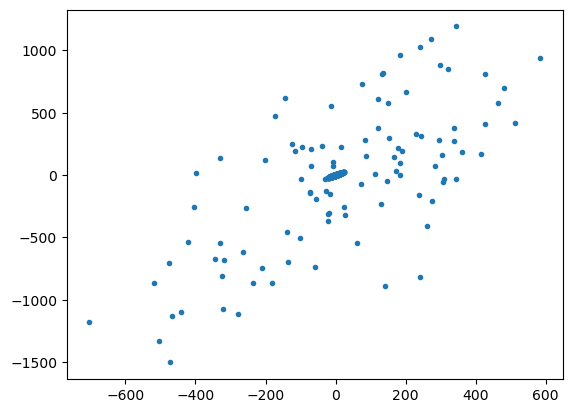

In [56]:
plt.plot(mus_scipy_complex.real.flatten(), mus_jax_conj_mod.real.flatten(), '.', color='tab:blue')

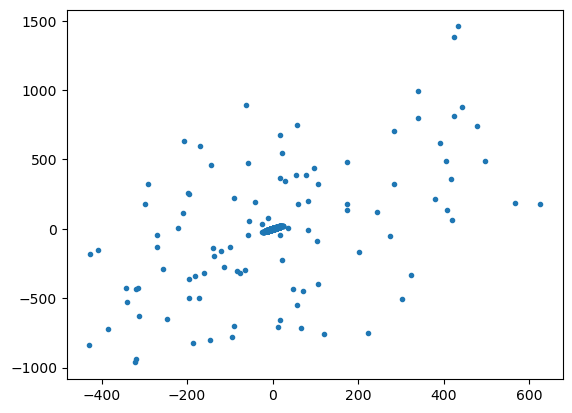

In [57]:
plt.plot(mus_scipy_complex.imag.flatten(), mus_jax_mod.imag.flatten(), '.', color='tab:blue')

In [197]:
mus_scipy_complex_full = jnp.zeros([500,K,L], dtype=complex)
mus_scipy_complex_full = mus_scipy_complex_full.at[:50,:,:].set(mus_scipy_complex)

mus_jax_full = jnp.zeros([500,K,L], dtype=complex)
mus_jax_full = mus_jax_full.at[:50,:,:].set(mus_jax_mod)

xs_scipy = jnp.fft.irfft(jnp.apply_along_axis(add0, 0, mus_scipy_complex_full), axis=0)
xs_jax = jnp.fft.irfft(jnp.apply_along_axis(add0, 0, mus_jax_full), axis=0)

In [198]:
def sample_xs(gamma, result):
   cfg = result['cfg']
   lcfg = cfg['latent']
   ocfg = cfg['obs']

   lrk = jr.key(lcfg.seed)
   L = lcfg.L

   zs = sample_from_gamma(lrk, gamma, L)
   zs_0dc = jnp.apply_along_axis(add0, 0, zs)
   xs = jnp.fft.irfft(zs_0dc, axis=0)

   return xs

result = res_load[1]
gamma = result['gamma_true_full']

xs = sample_xs(gamma, result)
obs = sample_obs(gamma, result)


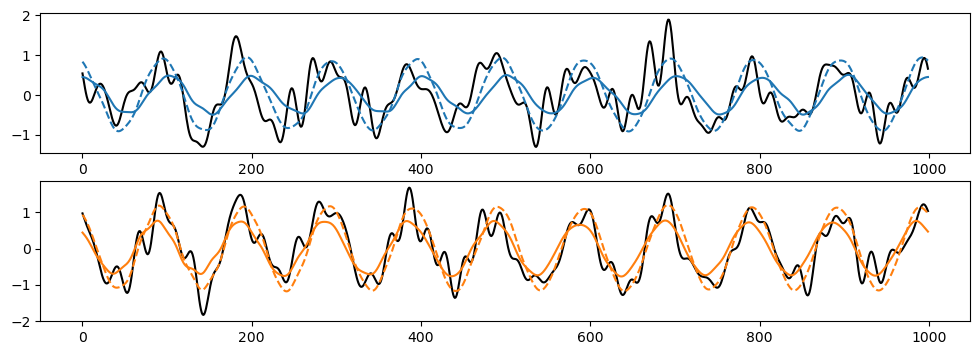

In [204]:
l = 9 
fig, ax = plt.subplots(2,1, figsize=(12,4))
ax[0].plot(xs[:,0,l], color='k')
ax[0].plot(xs_scipy[:,0,l], color='tab:blue')
ax[0].plot(xs_jax[:,0,l], linestyle='--', color='tab:blue')

ax[1].plot(xs[:,1,l], color='k')
ax[1].plot(xs_scipy[:,1,l], color='tab:orange')
ax[1].plot(xs_jax[:,1,l], linestyle='--', color='tab:orange')

In [194]:
hess_vals_scipy = jnp.concatenate([jnp.diag(hess_scipy[i,:,:]) for i in range(50)])
hess_vals_ts = jnp.concatenate([jnp.diag(hess_ts[i,:,:]) for i in range(50)])


In [27]:
hess_vals_scipy / hess_vals_ts

Array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [ ]:
from cohlib.jax.ts_gaussian import JvOExp, JaxOptim

In [ ]:
import jax
from cohlib.jax.observations import get_e_step_cost_func
obs_type = 'gaussian'
p = result['params']
p['K'] = 2
gpi = result['gamma_init']


cost_func = get_e_step_cost_func(obs, gpi, p, obs_type)
cost_grad = jax.grad(cost_func, holomorphic=True)
cost_hess = jax.hessian(cost_func, holomorphic=True)
# zs_est = zs_init

In [ ]:
def calc_obs_cost(z, data, K, N, nonzero_inds, obs_params, zs_flattened=False):
    if obs_type == 'gaussian':
        obs_cost_func = _obs_cost_gaussian
    elif obs_type == 'pp_relu':
        obs_cost_func = _obs_cost_pp_relu
    else:
        return NotImplementedError

    obs_cost = obs_cost_func(z, data, K, N, nonzero_inds, obs_params, zs_flattened)

    return obs_cost

In [ ]:
from cohlib.jax.dists import sample_from_gamma
sample = sample_from_gamma(jr.key(7), gamma, 5)

from cohlib.jax.observations import _obs_cost_gaussian, _obs_cost_pp_relu

In [ ]:
sample.shape

(500, 2, 5)

In [ ]:
obs.shape

(100, 2, 50)

In [ ]:
params['obs_var'] = 1
calc_obs_cost(sample[:,:,0], obs[:,:,0], 2, 500, nz, params)

TypeError: sub got incompatible shapes for broadcasting: (100, 2), (1000, 2).

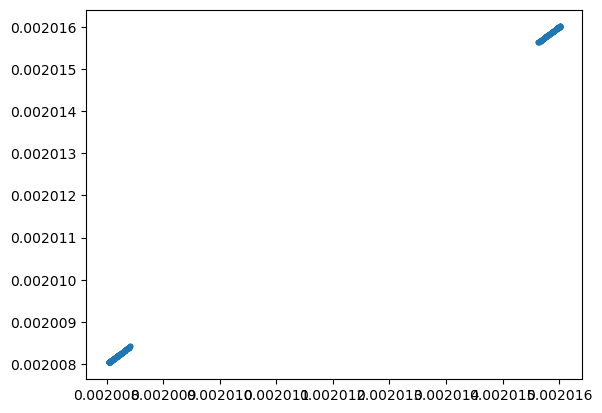

In [28]:
for j in range(2):
    mat_scipy = hess_scipy[j,:]
    mat_ts = hess_ts[j,:]
    plt.plot(jnp.diag(mat_scipy).flatten(), jnp.diag(mat_ts).flatten(), '.', color='tab:blue')

In [29]:
# Ok, next let's try Scipy m-step on oldmod-ts vs oldmod-scipy as a sanity check

In [30]:
from cohlib.alg.em_gaussian_obs import update_Gamma_complex
num_J_vars = 100
K = 2

In [31]:
gamma_update_scipy_via_old, sigmas_update_scipy_via_old = update_Gamma_complex(mus_scipy, hess_scipy, K, num_J_vars)
gamma_update_ts_via_old, sigmas_update_ts_via_old = update_Gamma_complex(mus_ts, hess_ts, K, num_J_vars)

In [32]:
jnp.all(jnp.isclose(gamma_update_scipy_via_old, gamma_update_ts_via_old, 1e-2))

Array(True, dtype=bool)

In [33]:
def spec_db(gamma, k=0):
    return 10*jnp.log10(gamma[:,k,k].real)
def spec(gamma, k=0):
    return gamma[:,k,k].real

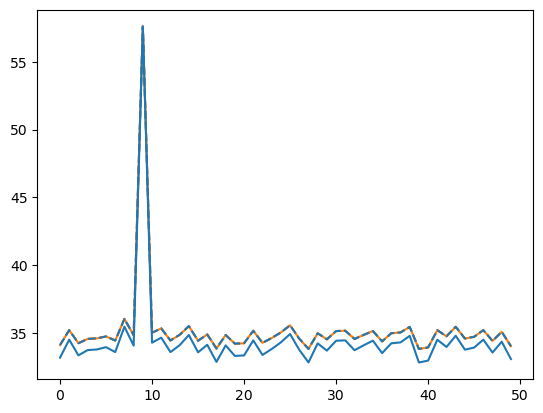

In [34]:
k = 0
func = spec_db
# func = spec
plt.plot(func(gamma_update_scipy_via_old), linestyle='--', color='tab:orange')
plt.plot(func(gamma_scipy), color='tab:orange')
plt.plot(func(gamma_update_ts_via_old), linestyle='--', color='tab:blue')
plt.plot(func(gamma_ts), color='tab:blue')

good, `gamma_ts` being the only one different is consistent with the idea that the m-step performed in jax_orig and all ts cases *is not* performing the same operation that `gamma_update_complex` in original scipy method is. (note again that the mus/Ups for the gamma_ts run are identical to the scipy case)


Sanity check #2 - if we convert the output from scipy model to the complex form, and use `m_step` (using the same code we used for the conversion in `ts_gaussian`), we should see the same effect

In [37]:
from cohlib.jax.ts_gaussian import conv_mu_old_r2c, deconstruct_Gamma_full_real_mod, deconstruct_Gamma_full_real
from cohlib.jax.observations import m_step

In [42]:
r = 0
ov2 = 2 
gamma_scipy = res_load_ts_oldmod_scipy[ov2]['track'][0][r]['gamma_rplus1'] 
gamma_ts = res_load_ts_oldmod_deconmod[ov2]['track'].track_em_data['gamma'][r]
gamma_ts_jax = res_load_ts_jax[ov2]['track'].track_em_data['gamma'][r]

mus_scipy = res_load_ts_oldmod_scipy[ov2]['track'][0][r]['mus'] 
mus_ts = res_load_ts_oldmod_deconmod[ov2]['track'].track_em_data['mus_real'][r]
mus_ts_jax = res_load_ts_jax[ov2]['track'].track_em_data['mus'][r]

hess_scipy = res_load_ts_oldmod_scipy[ov2]['track'][0][r]['Ups_invs'] 
hess_ts = res_load_ts_oldmod_deconmod[ov2]['track'].track_em_data['hessians_real'][r]
Upss_ts_jax = res_load_ts_jax[ov2]['track'].track_em_data['Upss'][r]


NameError: name 'res_load_ts_jax' is not defined

In [53]:
gamma_update_scipy_via_old, sigmas_update_scipy_via_old = update_Gamma_complex(mus_scipy, hess_scipy, K, num_J_vars)
gamma_update_ts_via_old, sigmas_update_ts_via_old = update_Gamma_complex(mus_ts, hess_ts, K, num_J_vars)

In [54]:
J = 50
mus_scipy_complex = jnp.stack([conv_mu_old_r2c(mus_scipy[l,:], K) for l in range(L)], axis=-1)
hess_scipy_complex = jnp.stack([deconstruct_Gamma_full_real_mod(hess_scipy[l,:,:], K, num_J_vars) for l in range(L)], axis=-1)
hess_scipy_complex_mod = jnp.stack([deconstruct_Gamma_full_real_mod(hess_scipy[l,:,:]/2, K, num_J_vars) for l in range(L)], axis=-1)
hess_inv_scipy_complex = jnp.stack([jnp.linalg.inv(hess_scipy_complex[:,:,:,l]) for l in range(L)], axis=-1)
hess_inv_scipy_complex_mod = jnp.stack([jnp.linalg.inv(hess_scipy_complex_mod[:,:,:,l]) for l in range(L)], axis=-1)
mus_outer_scipy_complex = jnp.einsum('jkl,jil->jkil', mus_scipy_complex, mus_scipy_complex.conj())

gamma_update_scipy_via_new = m_step(mus_outer_scipy_complex, hess_inv_scipy_complex)
gamma_update_scipy_via_new2 = m_step(mus_outer_scipy_complex, hess_inv_scipy_complex_mod)

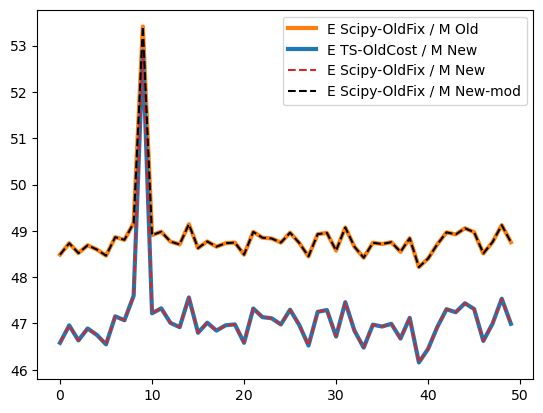

In [55]:
plt.plot(func(gamma_update_scipy_via_old), linewidth=3, color='tab:orange', label='E Scipy-OldFix / M Old')
# plt.plot(func(gamma_update_ts_via_old), color='tab:blue')
plt.plot(func(gamma_ts), color='tab:blue', linewidth=3, label='E TS-OldCost / M New')

plt.plot(func(gamma_update_scipy_via_new), linestyle='--', color='tab:red', label='E Scipy-OldFix / M New')
plt.plot(func(gamma_update_scipy_via_new2), linestyle='--', color='k', label='E Scipy-OldFix / M New-mod')
plt.legend()
# deconstruct uses transform

In [ ]:
# So this looks consistent now
# Next sanity check would be to see if we can see the same affect in jax m-step

In [62]:
mus_outer_jax = jnp.einsum('jkl,jil->jkil', mus_ts_jax, mus_ts_jax.conj())
Upss_ts_jax_mod = 2*Upss_ts_jax.copy()

gamma_update_ts_jax = m_step(mus_outer_jax, Upss_ts_jax)
gamma_update_ts_jax_mod = m_step(mus_outer_jax, Upss_ts_jax_mod)

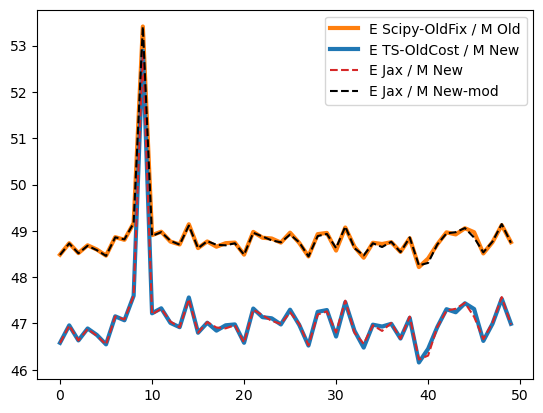

In [63]:
plt.plot(func(gamma_update_scipy_via_old), linewidth=3, color='tab:orange', label='E Scipy-OldFix / M Old')
# plt.plot(func(gamma_update_ts_via_old), color='tab:blue')
plt.plot(func(gamma_ts), color='tab:blue', linewidth=3, label='E TS-OldCost / M New')

plt.plot(func(gamma_update_ts_jax), linestyle='--', color='tab:red', label='E Jax / M New')
plt.plot(func(gamma_update_ts_jax_mod), linestyle='--', color='k', label='E Jax / M New-mod')
plt.legend()
# deconstruct uses transform

### Cool, so here is a change to the m_step in Jax code that should lead to 

Remaining: 

        - Convince ourselves that mathematically OldFix-Scipy is correct
        - Ditto update to Jax M-Step 
        - Probe diagonal vs non-diagonal Hessian (and inversion)
        - Write up everything 
        - Clean up code

Unresolved


        - small diff in jax original vs jax-ts

Question 

        - how does this effect OldFix-ts vs Jax behavior?

In [77]:
test.shape

(50, 2, 2, 50)

In [48]:

mus_outer = jnp.einsum('jkl,jil->jkil', mus_scipy_complex, mus_scipy_complex.conj())

# Upss = self.Upss
gamma_update = m_step(mus_outer, Upss)

In [69]:
# Sanity check #3 - (reverse #2 - convert output of jax to real format and use scipy update)
# convert (using existing code) jax mus/ups into 'old' form and comparing
from cohlib.jax.ts_gaussian import conv_mu_new_c2r, construct_Gamma_full_real

# 2*construct_Gamma_full_real

In [ ]:
r = 0
ov2 = 1 
gamma_scipy = res_load_ts_oldmod_scipy[ov2]['track'][0][r]['gamma_rplus1'] 
gamma_ts = res_load_ts_oldmod_deconmod[ov2]['track'].track_em_data['gamma'][r]
# TODO use res_load and res_load_ts_jax here 

mus_scipy = res_load_ts_oldmod_scipy[ov2]['track'][0][r]['mus'] 
mus_ts = res_load_ts_oldmod_deconmod[ov2]['track'].track_em_data['mus_real'][r]

hess_scipy = res_load_ts_oldmod_scipy[ov2]['track'][0][r]['Ups_invs'] 
hess_ts = res_load_ts_oldmod_deconmod[ov2]['track'].track_em_data['hessians_real'][r]

In [ ]:
gamma_update_scipy_via_old, sigmas_update_scipy_via_old = update_Gamma_complex(mus_scipy, hess_scipy, K, num_J_vars)
gamma_update_ts_via_old, sigmas_update_ts_via_old = update_Gamma_complex(mus_ts, hess_ts, K, num_J_vars)


next we need to untangle why this is the case, and which is mathematically correct

we'll need to walk through what happens in ts update vs scipy update

In [71]:

# hess_ts_jax = res_ts_oldmod_deconmod['track'].track_em_data
res_load[ov2]

{'gamma': Array([[[ 3.54399867e-02+1.73544578e-15j,
           2.70565934e-02+7.14509483e-08j],
         [ 2.70565934e-02-7.14509412e-08j,
           6.93461001e-02+7.59067390e-15j]],
 
        [[ 5.37333861e-02+2.56198058e-14j,
           5.14760241e-03+2.21987170e-06j],
         [ 5.14760241e-03-2.21987170e-06j,
           5.83998077e-02+1.85598747e-15j]],
 
        [[ 3.02760787e-02-3.26953066e-15j,
           8.28168879e-04+9.75469561e-07j],
         [ 8.28168821e-04-9.75469561e-07j,
           4.37684245e-02-1.27180906e-15j]],
 
        [[ 4.12709601e-02+4.34251430e-15j,
          -3.24551878e-03+1.17440254e-06j],
         [-3.24551924e-03-1.17440266e-06j,
           3.11053935e-02+8.65180374e-15j]],
 
        [[ 3.67600359e-02-5.38367577e-15j,
           1.41047072e-02-1.44877220e-07j],
         [ 1.41047081e-02+1.44877234e-07j,
           4.53375317e-02+1.36221702e-15j]],
 
        [[ 3.10938284e-02+2.02753257e-16j,
           6.43313630e-03-1.63057257e-06j],
         [ 6.433136

In [ ]:
def conv_mu_old_c2r(mu_mat_complex, K):
    mu_v = conv_z_to_v(mu_mat_complex[:,:], axis=0)
    mu_v_flat = jnp.concatenate([mu_v[:,k] for k in range(K)])
    return mu_v_flat

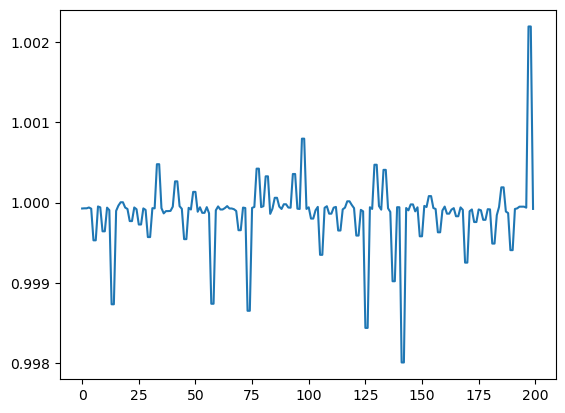

In [58]:
plt.plot((gamma_update_scipy_via_old.real / gamma_update_ts_via_old.real).flatten())

/scratch/286486.1.ood/ipykernel_2397120/3389094040.py:2: RuntimeWarning: invalid value encountered in divide
  ratio = gamma_update_ts_via_old.imag / gamma_update_scipy_via_old.imag


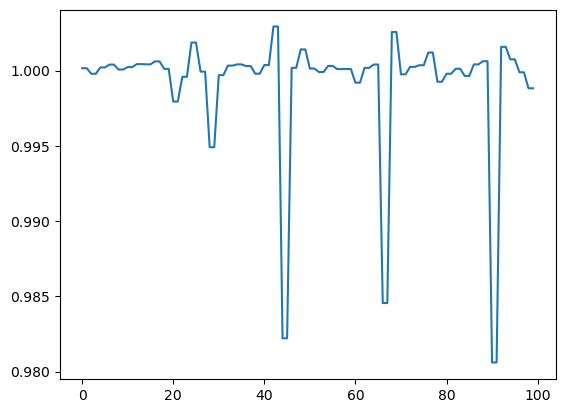

In [63]:
# ratio = gamma_update_scipy_via_old.imag / gamma_update_ts_via_old.imag
ratio = gamma_update_ts_via_old.imag / gamma_update_scipy_via_old.imag 
plt.plot(ratio[~jnp.isnan(ratio)].flatten())

In [60]:
plt.plot(mus_jax.flatten().real, mus_scipy

(50, 2, 50)

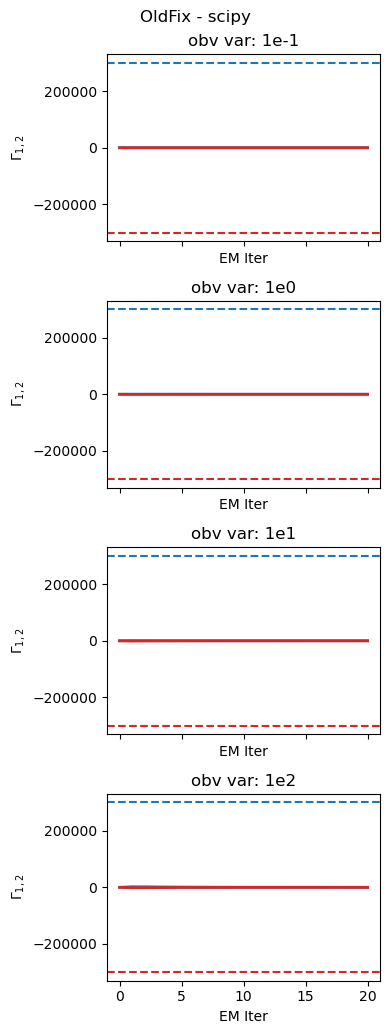

In [38]:
fig, ax = plt.subplots(4,1, figsize=(4,10.5), sharex=True)
for i, ov2 in enumerate(ovs):
    res_jax = res_load[ov2]
    # res_ts_jax[i] = res_load_ts_jax[ov2]

    scipy_old_gamma_emtrack = [res_load_ts_old_scipy[ov2]['track'][0][r]['gamma_rplus1'] for r in range(emiters)]
    scipy_oldmod_gamma_emtrack = [res_load_ts_oldmod_scipy[ov2]['track'][0][r]['gamma_rplus1'] for r in range(emiters)]

    gamma_init = res_jax['gamma_init']
    gamma_true = res_jax['gamma_true_full'][nz,:,:]
    j_ind = 9
    S_true = thr_coherence(gamma_true)
    S_init = thr_coherence(gamma_init)

    ax[i].axhline(gamma_true[j_ind,0,1].real, linestyle='--', color='tab:blue')
    ax[i].axhline(gamma_true[j_ind,0,1].imag, linestyle='--', color='tab:red')
    plot_cross_spec_em_iters(ax[i], scipy_oldmod_gamma_emtrack, gamma_init, 5)
    # plot_cross_spec_em_iters(ax[i], res_jax['track']['gamma'], gamma_init, j_ind)
    ax[i].set_title(f'obv var: 1e{ov2}')
    ax[i].set_xlabel('EM Iter')
    ylabel = r"$\Gamma_{1,2}$"
    ax[i].set_ylabel(ylabel)

    # ax[i][0].set_ylim([-0.1,1])
    # ax[i][1].set_ylim([-0.1,1])
    # ax[i][2].set_ylim([-0.1,1])

    plt.tight_layout()
fig.suptitle('OldFix - scipy')
plt.tight_layout()

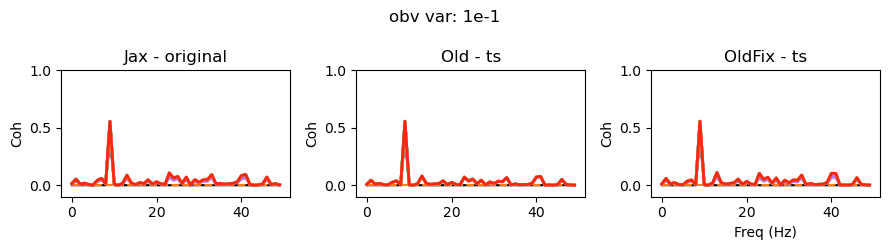

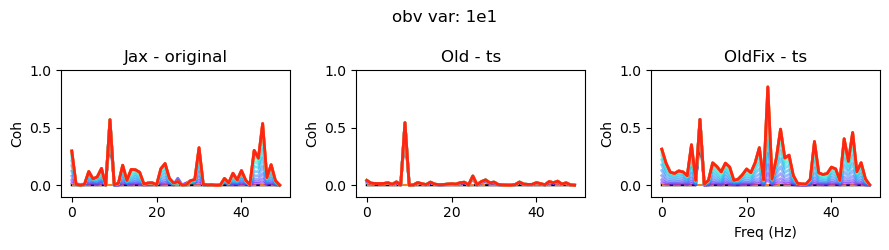

In [31]:
for ov2 in ovs:
    res_jax = res_load[ov2]
    # res_ts_jax = res_load_ts_jax[ov2]

    res_ts_old_deconmod = res_load_ts_old_deconmod[ov2]
    res_ts_oldmod_deconmod = res_load_ts_oldmod_deconmod[ov2]

    gamma_init = res_jax['gamma_init']
    gamma_true = res_jax['gamma_true_full'][nz,:,:]
    S_true = thr_coherence(gamma_true)
    S_init = thr_coherence(gamma_init)

    fig, ax = plt.subplots(1,3, figsize=(9,2.5), sharex=True)
    fig.suptitle(f'obv var: 1e{ov2}')
    ax[0].plot(S_true, 'k')
    ax[1].plot(S_true, 'k')
    ax[2].plot(S_true, 'k')
    ax[0].plot(S_init, '--', color='tab:orange', label='Init')
    ax[1].plot(S_init, '--', color='tab:orange')
    ax[2].plot(S_init, '--', color='tab:orange')
    plot_coh_em_iters(ax[0], res_jax['track']['gamma'])
    ax[0].set_title('Jax - original')
    plot_coh_em_iters(ax[1], res_ts_old_deconmod['track'].track_em_data['gamma'])
    ax[1].set_title('Old - ts')
    plot_coh_em_iters(ax[2], res_ts_oldmod_deconmod['track'].track_em_data['gamma'])
    ax[2].set_title('OldFix - ts')
    ax[2].set_xlabel('Freq (Hz)')
    ylabel = "Coh"
    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel(ylabel)
    ax[2].set_ylabel(ylabel)
    # plot_spec_em_iters(ax[1], res_ts_oldmod_deconmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], res_ts_oldmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[2], scipy_oldmod_gamma_emtrack, k, dB=True)
    ax[0].set_ylim([-0.1,1])
    ax[1].set_ylim([-0.1,1])
    ax[2].set_ylim([-0.1,1])

    plt.tight_layout()

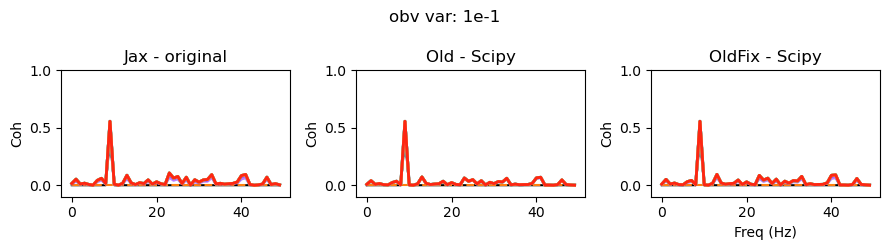

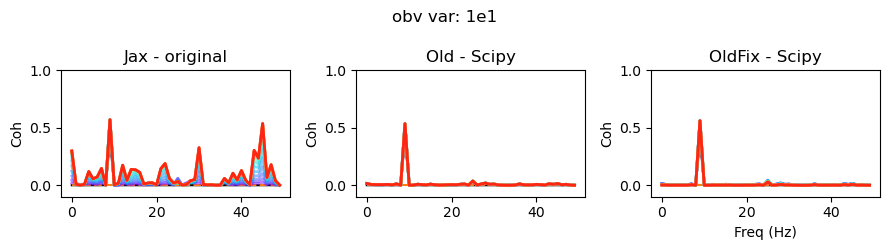

In [32]:
for ov2 in ovs:
# for ov2 in [-3,-2,-1,0]:
    res_jax = res_load[ov2]

    scipy_old_gamma_emtrack = [res_load_ts_old_scipy[ov2]['track'][0][r]['gamma_rplus1'] for r in range(emiters)]
    scipy_oldmod_gamma_emtrack = [res_load_ts_oldmod_scipy[ov2]['track'][0][r]['gamma_rplus1'] for r in range(emiters)]

    gamma_init = res_jax['gamma_init']
    gamma_true = res_jax['gamma_true_full'][nz,:,:]
    S_true = thr_coherence(gamma_true)
    S_init = thr_coherence(gamma_init)

    fig, ax = plt.subplots(1,3, figsize=(9,2.5), sharex=True)
    fig.suptitle(f'obv var: 1e{ov2}')
    ax[0].plot(S_true, 'k')
    ax[1].plot(S_true, 'k')
    ax[2].plot(S_true, 'k')
    ax[0].plot(S_init, '--', color='tab:orange', label='Init')
    ax[1].plot(S_init, '--', color='tab:orange')
    ax[2].plot(S_init, '--', color='tab:orange')
    plot_coh_em_iters(ax[0], res_jax['track']['gamma'])
    ax[0].set_title('Jax - original')
    plot_coh_em_iters(ax[1], scipy_old_gamma_emtrack)
    ax[1].set_title('Old - Scipy')
    plot_coh_em_iters(ax[2], scipy_oldmod_gamma_emtrack)
    ax[2].set_title('OldFix - Scipy')
    ax[2].set_xlabel('Freq (Hz)')
    ylabel = "Coh"
    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel(ylabel)
    ax[2].set_ylabel(ylabel)
    # plot_spec_em_iters(ax[1], res_ts_oldmod_deconmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], res_ts_oldmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[2], scipy_oldmod_gamma_emtrack, k, dB=True)
    ax[0].set_ylim([-0.1,1])
    ax[1].set_ylim([-0.1,1])
    ax[2].set_ylim([-0.1,1])

    plt.tight_layout()

In [ ]:
from cohlib.jax.ts_gaussian import JvOExp, JaxOptim

In [ ]:
result = res_load[1]
gamma = result['gamma_true_full']

obs = sample_obs(gamma[nz,:,:], result)

In [ ]:
import jax
from cohlib.jax.observations import get_e_step_cost_func
obs_type = 'gaussian'
p = result['params']
p['K'] = 2
gpi = result['gamma_init']


cost_func = get_e_step_cost_func(obs, gpi, p, obs_type)
cost_grad = jax.grad(cost_func, holomorphic=True)
cost_hess = jax.hessian(cost_func, holomorphic=True)
# zs_est = zs_init

In [ ]:
def calc_obs_cost(z, data, K, N, nonzero_inds, obs_params, zs_flattened=False):
    if obs_type == 'gaussian':
        obs_cost_func = _obs_cost_gaussian
    elif obs_type == 'pp_relu':
        obs_cost_func = _obs_cost_pp_relu
    else:
        return NotImplementedError

    obs_cost = obs_cost_func(z, data, K, N, nonzero_inds, obs_params, zs_flattened)

    return obs_cost

In [ ]:
from cohlib.jax.dists import sample_from_gamma
sample = sample_from_gamma(jr.key(7), gamma, 5)

from cohlib.jax.observations import _obs_cost_gaussian, _obs_cost_pp_relu

In [ ]:
sample.shape

(500, 2, 5)

In [ ]:
obs.shape

(100, 2, 50)

In [ ]:
params['obs_var'] = 1
calc_obs_cost(sample[:,:,0], obs[:,:,0], 2, 500, nz, params)

TypeError: sub got incompatible shapes for broadcasting: (100, 2), (1000, 2).

In [45]:
from cohlib.conv import conv_v_to_z, conv_z_to_v
def conv_mu_old_r2c(grad_vec_real, K):
    rs = grad_vec_real.reshape(2,-1).swapaxes(0,1)
    grad_vec_complex = conv_v_to_z(rs, axis=0)
    return grad_vec_complex

def conv_mu_old_c2r(mu_mat_complex):
    mu_v = conv_z_to_v(mu_mat_complex[:,:], axis=0)
    mu_v_flat = jnp.concatenate([mu_v[:,k] for k in range(K)])
    return mu_v_flat

In [49]:
r = 5
mus_real = res_load_ts_oldmod_scipy[ov2]['track'][0][r]['mus']
mus_complex = res_ts_oldmod_deconmod['track'].track_em_data['mus'][r]

orig_complex = mus_complex[:,:,0]
test_c2r = conv_mu_old_c2r(orig_complex)
test_r2c = conv_mu_old_r2c(test_c2r, K)